In [1]:
import domain_adapt_run.domain_adapt_run.constants as constants
cache_folder_name = 'KMM_weighted_kernel_sufficient_dimension_reduction_cleaned_more'
seed = 44

In [2]:
import autograd.numpy as np
np.random.seed(seed)
import python_utils.python_utils.basic as basic
import python_utils.python_utils.caching as caching
log_folder = '%s/%s' % (constants.cache_folder, cache_folder_name)
caching.init(constants.cache_folder, constants.which_hash, basic.archiver(log_folder))
%load_ext autoreload
%autoreload 2

[Errno 17] File exists: '/Users/fultonw/Documents/projects/runs/domain_adapt_run/cache/KMM_weighted_kernel_sufficient_dimension_reduction_cleaned_more'


In [3]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display_pretty, display_html
import python_utils.python_utils.basic as basic
import pandas as pd
import pdb
import itertools
import functools
import scipy.stats, scipy
import cvxopt
import domain_adapt.domain_adapt.kernels as kernels
import pymanopt
import pprint, autograd

Couldn't import dot_parser, loading of dot files will not be possible.


## define data

In [4]:
# x is generated based on u coordinates.  v basis coordinates determines y 
x_dim = 2
u_dim = 1
v_dim = 2
y_dim = 1
u_perp_dim = x_dim - u_dim
#u_perp_dim = 0
#u_bases = kernels.ortho(np.array([[1.,0.],[0.,1.]]).T)
u_bases = kernels.ortho(np.array([[1.,0.]]).T)
if u_perp_dim > 0:
    u_perp_bases = kernels.ortho(np.array([[0.,1.]]).T)
v_perp_dim = x_dim - v_dim
v_bases = kernels.ortho(np.array([[1.,0.]]).T)

In [ ]:
#
desired_dim = 1

In [5]:
# define train u distribution
p_u_train_dist = scipy.stats.multivariate_normal(mean=4*np.ones(shape=u_dim), cov=np.eye(u_dim)*3.8)
#p_u_train_dist = scipy.stats.uniform(loc=(0.5**2+0.5**2)**.5, scale=8.**.5 - ((0.5**2+0.5**2)**.5))
p_u_train_pdf = p_u_train_dist.pdf
p_u_train_sample = p_u_train_dist.rvs

In [6]:
# define test u distribution
p_u_test_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=u_dim), cov=np.eye(u_dim)*1.2)
#p_u_test_dist = scipy.stats.uniform(loc=0., scale=2.**.5)
p_u_test_pdf = p_u_test_dist.pdf
p_u_test_sample = p_u_test_dist.rvs

In [7]:
# define shared u_perp distribution
if u_perp_dim > 0:
#    p_u_perp_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=u_perp_dim), cov=np.eye(u_perp_dim)*0.029)
#    p_u_perp_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=u_perp_dim), cov=np.eye(u_perp_dim)*0.049)
    p_u_perp_dist = scipy.stats.multivariate_normal(mean=np.zeros(shape=u_perp_dim))
    p_u_perp_pdf = p_u_perp_dist.pdf
    p_u_perp_sample = p_u_perp_dist.rvs

In [8]:
f_v = lambda v: 1*np.ones(u_dim).dot(v)
y_var = 0.002
p_y_noise_sample = scipy.stats.multivariate_normal(mean=np.zeros(shape=y_dim),cov=np.eye(y_dim)*y_var).rvs
p_y_given_v_sample = lambda v: f_v(v) + p_y_noise_sample()

In [9]:
# specify number of data to generate
num_train = 200
num_test = 200

In [10]:
# generate data
expand = lambda s: s.reshape(len(s),1) if len(s.shape) == 1 else s
us_train = expand(np.array([p_u_train_sample() for i in xrange(num_train)]))
us_test = expand(np.array([p_u_test_sample() for i in xrange(num_test)]))
if u_perp_dim > 0:
    us_perp_train = expand(np.array([p_u_perp_sample() for i in xrange(num_train)]))
    us_perp_test = expand(np.array([p_u_perp_sample() for i in xrange(num_test)]))
xs_train = np.dot(us_train, u_bases.T)
xs_test = np.dot(us_test, u_bases.T)
if u_perp_dim > 0:
    xs_train += np.dot(us_perp_train, u_perp_bases.T)
    xs_test += np.dot(us_perp_test, u_perp_bases.T)
vs_train = np.dot(xs_train, v_bases)
vs_test = np.dot(xs_test, v_bases)
ys_train = np.array([p_y_given_v_sample(v) for v in vs_train])
ys_test = np.array([p_y_given_v_sample(v) for v in vs_test])

## plot raw data

In [11]:
# define some constants for plotting
xs_plot_dim_1 = 0
xs_plot_dim_2 = 1
x_low, x_high = -2, 4
y_low, y_high = -2, 4
color_wheel = itertools.cycle(['c','b','k','g'])

/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


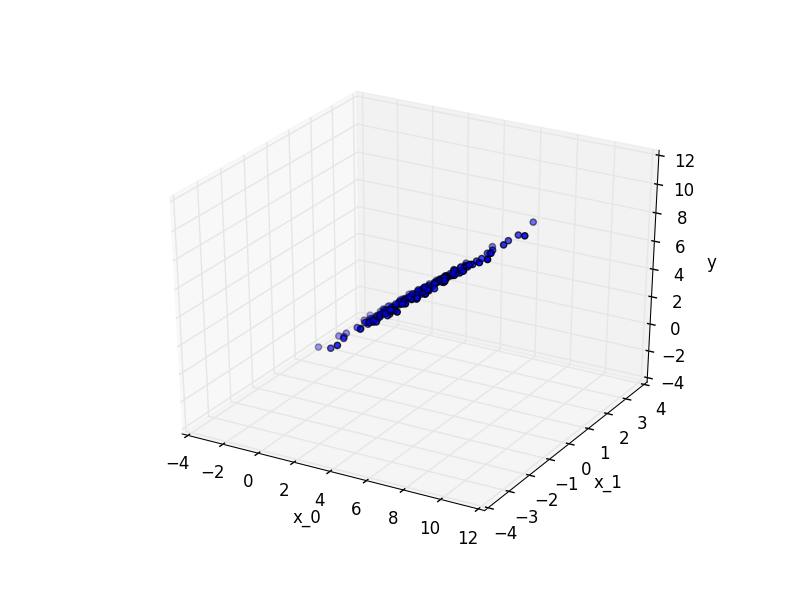

In [12]:
# plot train data, 3d
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs_train[:,xs_plot_dim_1],xs_train[:,xs_plot_dim_2],ys_train)
ax.set_xlabel('x_%d' % xs_plot_dim_1)
ax.set_ylabel('x_%d' % xs_plot_dim_2)
ax.set_zlabel('y')
basic.display_fig_inline(fig)

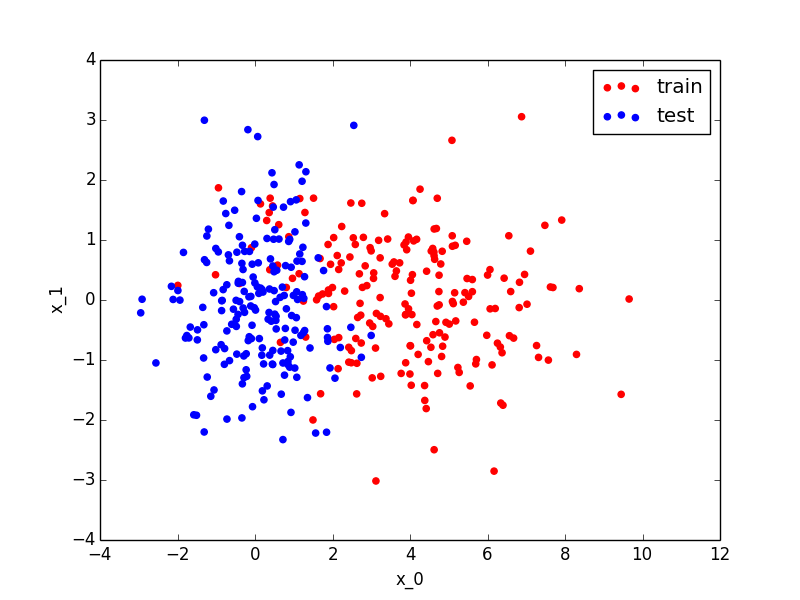

In [13]:
# plot train xs, test xs, 2d
fig, ax = plt.subplots()
ax.scatter(xs_train[:,xs_plot_dim_1],xs_train[:,xs_plot_dim_2], color='r', label='train')
ax.scatter(xs_test[:,xs_plot_dim_1],xs_test[:,xs_plot_dim_2], color='b', label='test')
ax.set_xlabel('x_%d' % xs_plot_dim_1)
ax.set_ylabel('x_%d' % xs_plot_dim_2)
ax.legend()
basic.display_fig_inline(fig)

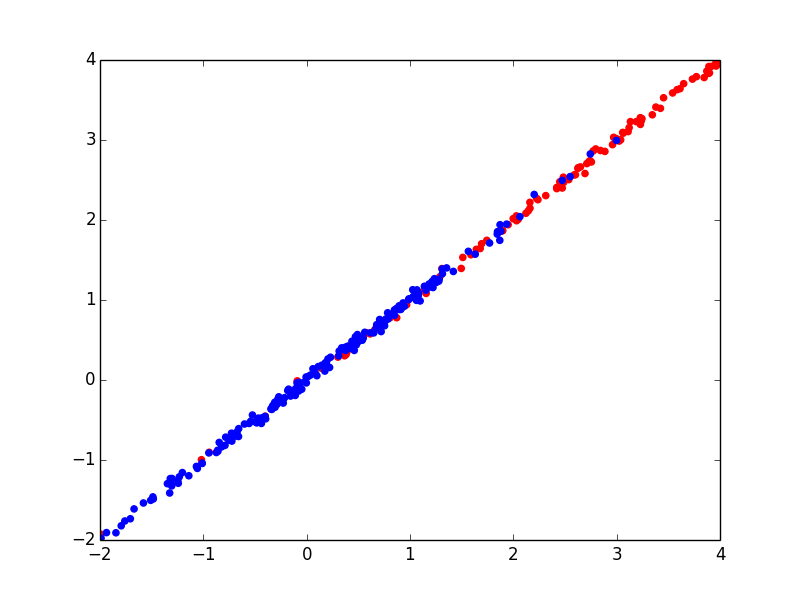

In [14]:
# plot ys1 vs vs1
fig, ax = plt.subplots()
ax.scatter(xs_train[:,0], ys_train, color='r')
ax.scatter(xs_test[:,0], ys_test, color='b')
ax.set_xlim((x_low,x_high))
ax.set_ylim((y_low,y_high))
basic.display_fig_inline(fig)

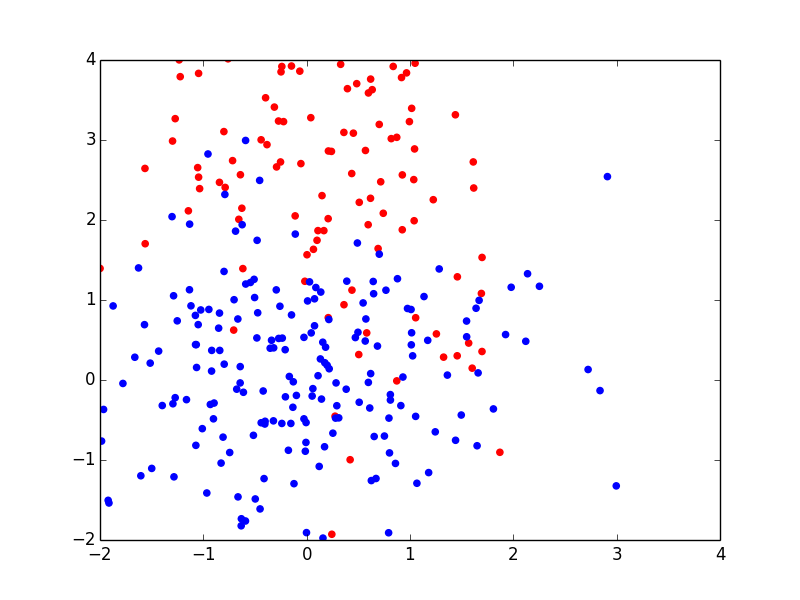

In [15]:
# plot ys2 vs vs2
fig, ax = plt.subplots()
ax.scatter(xs_train[:,1], ys_train, color='r')
ax.scatter(xs_test[:,1], ys_test, color='b')
ax.set_xlim((x_low,x_high))
ax.set_ylim((y_low,y_high))
basic.display_fig_inline(fig)

## define and check supervised term in objective function

In [16]:
#
def weighted_lsqr_loss(ws, xs, ys):
    ws = np.ones(len(xs))
    N = xs.shape[0]
    W = ws * np.eye(N)
    #ans2 = ys.T.dot(W).dot(np.eye(N)-xs.dot(np.linalg.inv(xs.T.dot(W).dot(xs))).dot(xs.T).dot(W)).dot(ys)
    temp1 = np.linalg.inv(np.dot(xs.T*ws,xs))
    temp2 = np.dot(np.dot(xs,temp1),xs.T*ws)
    #print 'ys',ys
    #print 'ws',ws
    #print ys*ws
    temp4 = ys*ws
    temp3 = temp4 - np.dot(temp4,temp2)
    ans = np.sum(np.dot(temp3,ys))
    #print ans2, ans, np_weighted_lsqr_loss(ws, xs, ys), np.linalg.inv(xs.T.dot(W).dot(xs)).shape, ws.shape, xs.shape, ys.shape
    return ans

def np_weighted_lsqr_loss(ws, xs, ys):
    xsw = xs * np.sqrt(ws[:,np.newaxis])
    ysw = ys * np.sqrt(ws)
    c = np.linalg.lstsq(xsw, ysw)[0]
    err = ys - xs.dot(c)
    return np.sum(np.diag(ws).dot(err * err))

test_ws = np.linspace(0.1, 2., len(xs_train))
print 'my loss:', weighted_lsqr_loss(test_ws, xs_train, ys_train)
print 'np loss:', np_weighted_lsqr_loss(test_ws, xs_train, ys_train)

my loss: 0.357687555381
np loss: 0.402554575457


## define hyperparameters

In [17]:
#
def mat_median(m):
    l = len(m)
    v = np.arange(l).reshape((l,1))
    return np.median(m[v != v.T])

def median_distance(xs1, xs2):
    if len(xs1.shape) == 1:
        diff = xs1[:,np.newaxis] - xs2[np.newaxis,:]
        norms = np.sum(diff * diff, axis=1) ** 0.5
    elif len(xs1.shape) == 2:
        diff = xs1[:,np.newaxis,:] - xs2[np.newaxis,:,:]
        norms = np.sum(diff * diff, axis=2) ** 0.5
    return mat_median(norms)

In [18]:
# define stuff for SDR
#sigma = 0.1
#sigma = 0.5
#sigma = 0.5
#SDR_get_K = functools.partial(kernels.get_gaussian_K, sigma)
#get_SDR_get_K = lambda P,step: SDR_get_K
get_SDR_get_K = lambda P,step: lambda xs1, xs2: xs1
#get_SDR_get_K = lambda P,step: functools.partial(kernels.get_gaussian_K, (0.5**step) * median_distance(np.dot(xs_train,P),np.dot(xs_train,P)))
#get_SDR_get_K = lambda P,step: functools.partial(kernels.get_gaussian_K, (0.5**step) * median_distance(np.dot(xs_train,P),np.dot(xs_test,P)))

#SDR_get_Ky = lambda P,step: functools.partial(kernels.get_gaussian_K, median_distance(ys_train, ys_train))
#get_SDR_get_Ky = lambda P,step: SDR_get_Ky
get_SDR_get_Ky = lambda P,step: lambda ys1, ys2: ys1
#get_SDR_get_Ky = get_SDR_get_K
SDR_eps = 0.01

In [19]:
# define stuff for KMM
#B_max = 100
#B_max = 100
B_max = 10.
KMM_eps = 0.01
#get_KMM_get_K = lambda P,step: KMM_get_K
#get_KMM_get_K = get_SDR_get_K
sigma = 0.5
KMM_get_K = functools.partial(kernels.get_gaussian_K, sigma)
#get_KMM_get_K = lambda P,step: KMM_get_K
get_KMM_get_K = lambda P,step: functools.partial(kernels.get_gaussian_K, 1.*median_distance(np.dot(np.vstack((xs_train,xs_test)),P),np.dot(np.vstack((xs_train,xs_test)),P)))
get_KMM_get_K = lambda P,step: functools.partial(kernels.get_gaussian_K, 1.)
#get_KMM_get_K = lambda P,step: functools.partial(kernels.get_gaussian_K, (0.5**step) * median_distance(np.dot(xs_train,P),np.dot(xs_train,P)))
#get_KMM_get_K = lambda P,step: functools.partial(kernels.get_gaussian_K, (0.5**step) * median_distance(np.dot(xs_train,P),np.dot(xs_test,P)))


In [21]:
# see what bandwidth is like for some random projections
[get_KMM_get_K(kernels.ortho(np.random.uniform(size=(x_dim,v_dim))),0).args[0] for i in xrange(10)]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [22]:
# define objective fxn
tradeoff = 0.1
#obj_from_wsopt_and_Ks = lambda Ky, Ku, wsopt: weighted_lsqr_loss(wsopt, Ku, Ky)
obj_from_wsopt_and_Ks = lambda Ky, Ku, wsopt: kernels.ws_distance(wsopt) #+ (tradeoff * weighted_lsqr_loss(wsopt, Ku, Ky))
#obj_from_wsopt_and_Ks = lambda Ky, Ku, wsopt: kernels.ws_distance(wsopt)# + (tradeoff * kernels.get_trace_from_ws_and_Ks(SDR_eps, Ky, Ku, None)) # set ws to None here to turn off weighting of SDR

In [ ]:
# define necessary gradients or their constructors
dobj_dwsopt = autograd.jacobian(lambda wsopt, Ky, Ku: obj_from_ws_and_Ks(Ky, Ku, wsopt))

def get_dobj_dP_thru_Ku(xs_train, SDR_get_K, Ky):
    
    def obj_from_P_and_wsopt(P, wsopt):
        us_train = np.dot(xs_train, P)
        Ku = SDR_get_K(us_train, us_train)
        return obj_from_ws_and_Ks(Ky, Ku, wsopt)

    dobj_dP_thru_Ku = autograd.jacobian(obj_from_P_and_wsopt)
    
    return dobj_dP_thru_Ku

In [23]:
# define linear system solvers
reg_lstsq_solver = lambda A,b: scipy.sparse.linalg.lsmr(A,b)[0]
lstsq_solver = lambda A,b: np.linalg.lstsq(A, b)[0]
cg_solver = lambda A,b: scipy.sparse.linalg.cg(A, b)[0]
#lin_solver = lstsq_solver
#lin_solver = cg_solver
lin_solver = reg_lstsq_solver

In [24]:
# define qp solver
cvxopt_solver = kernels.cvxopt_solver

In [25]:
# define fxn that takes in stuff that changes over iterations
get_obj_and_dobj_dP = lambda KMM_get_K, SDR_get_K, SDR_get_Ky: kernels.get_obj_and_obj_gradient(KMM_get_K, B_max, KMM_eps, SDR_get_K, SDR_get_Ky, obj_from_wsopt_and_Ks, dobj_dwsopt, get_dobj_dP_thru_Ku, lin_solver, cvxopt_solver, xs_train, xs_test, ys_train)

## before optimizing, get a sense of what answer should be

test KMM sigma: 1.0
test_P: [[ 1.]
 [ 0.]] obj_val: 0.0455165913319


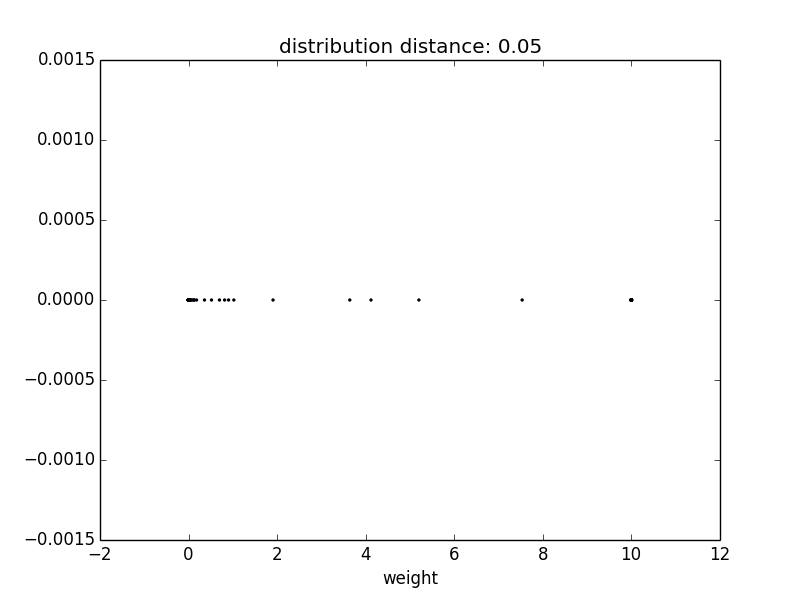

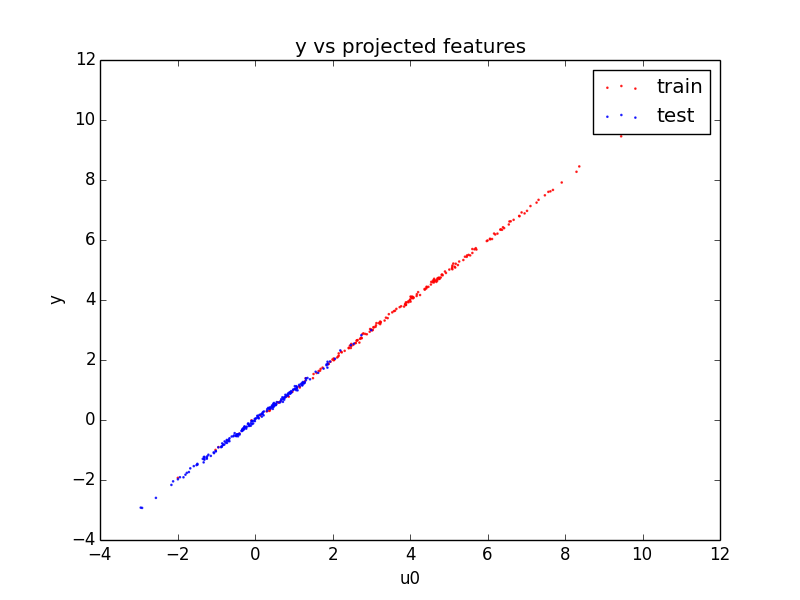

test_P: [[ 0.99227788]
 [ 0.12403473]] obj_val: 0.0447540178002


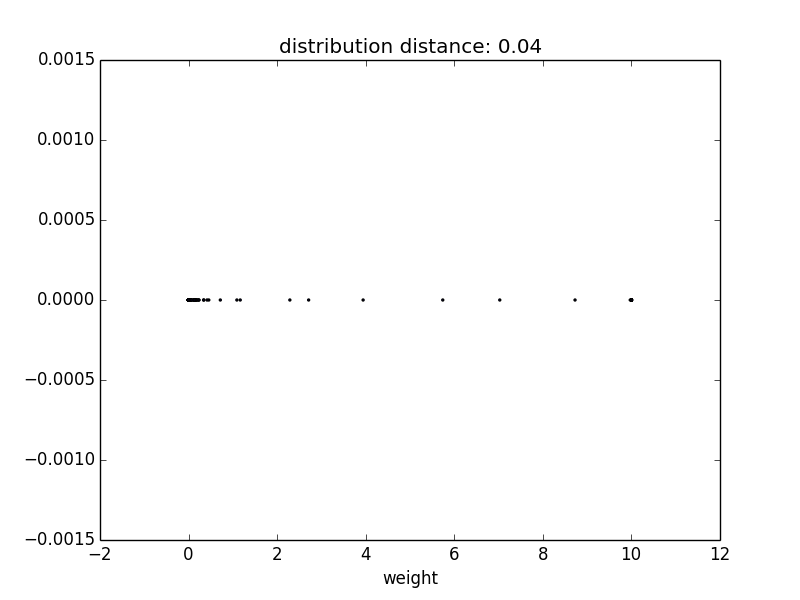

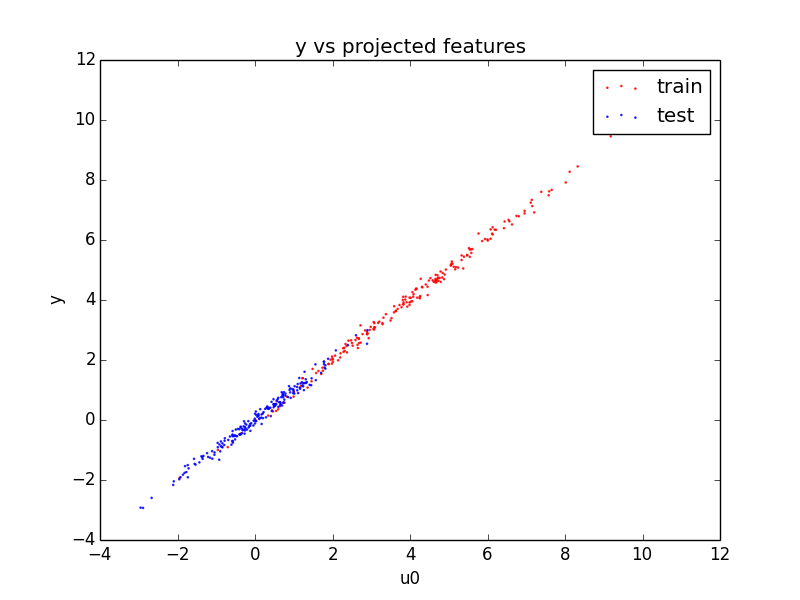

test_P: [[ 0.96152395]
 [ 0.27472113]] obj_val: 0.0453281851447


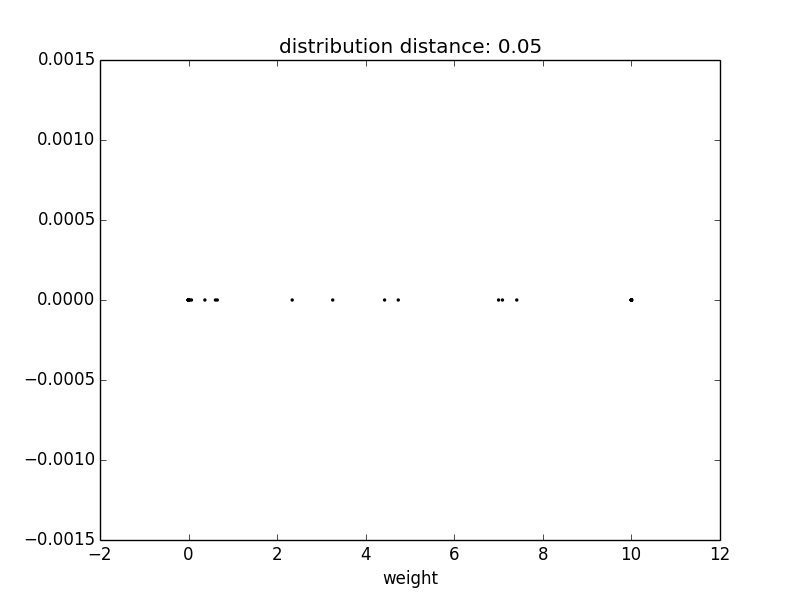

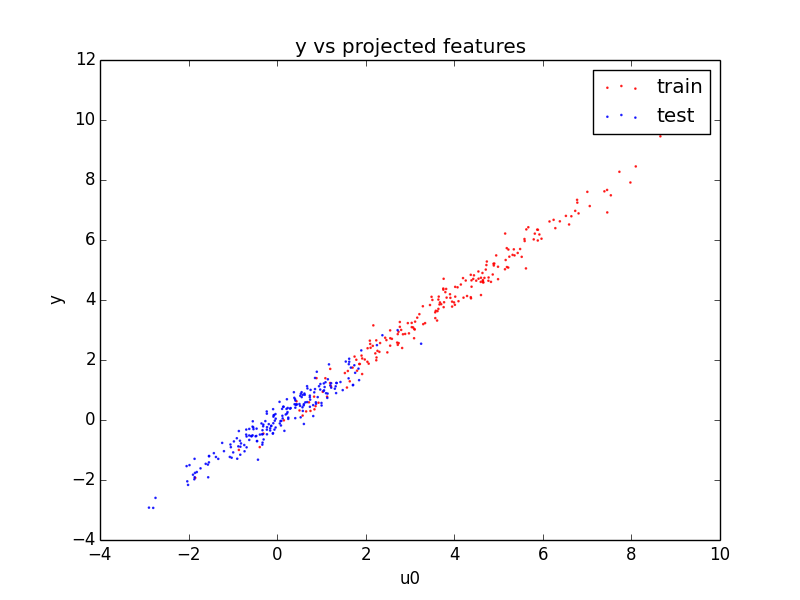

test_P: [[ 0.89442719]
 [ 0.4472136 ]] obj_val: 0.0445899078358


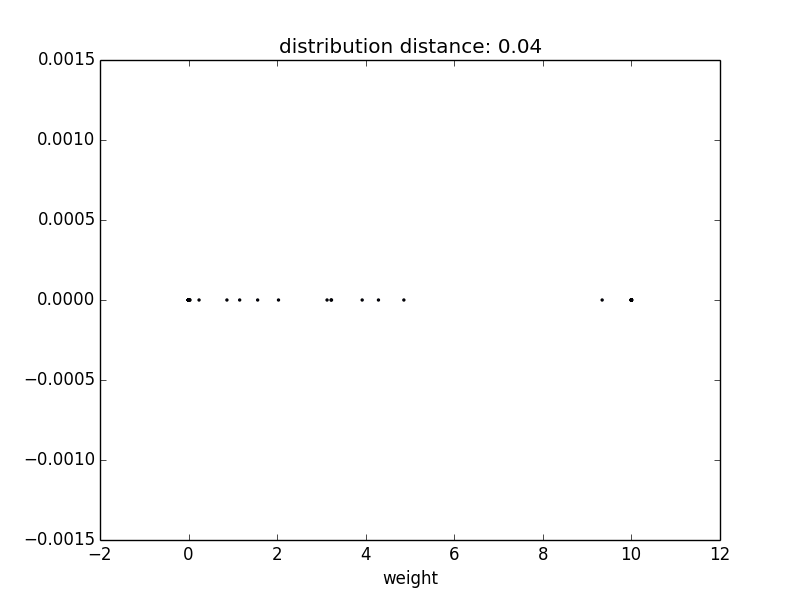

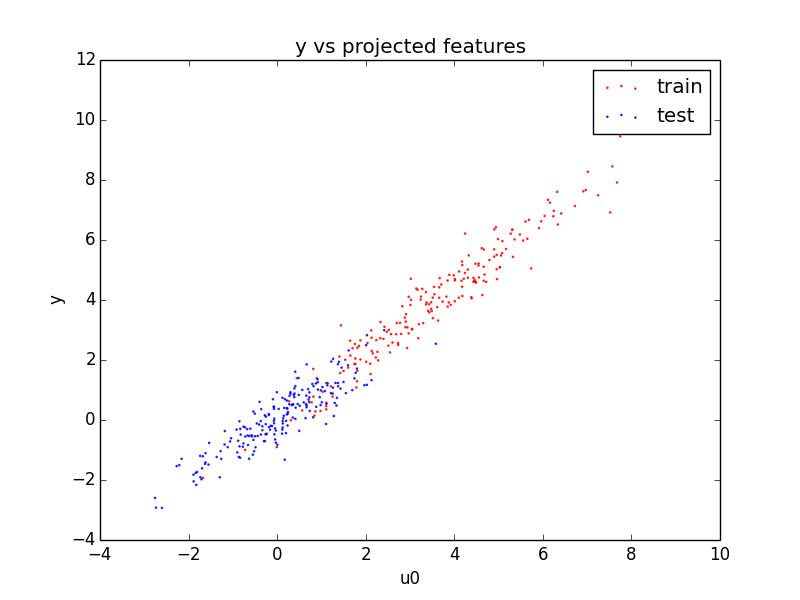

test_P: [[ 0.78086881]
 [ 0.62469505]] obj_val: 0.0463572254817


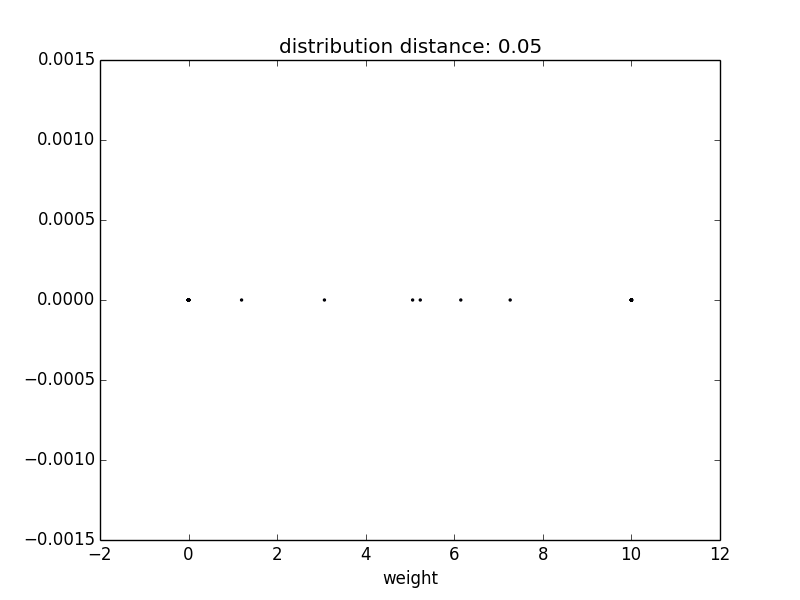

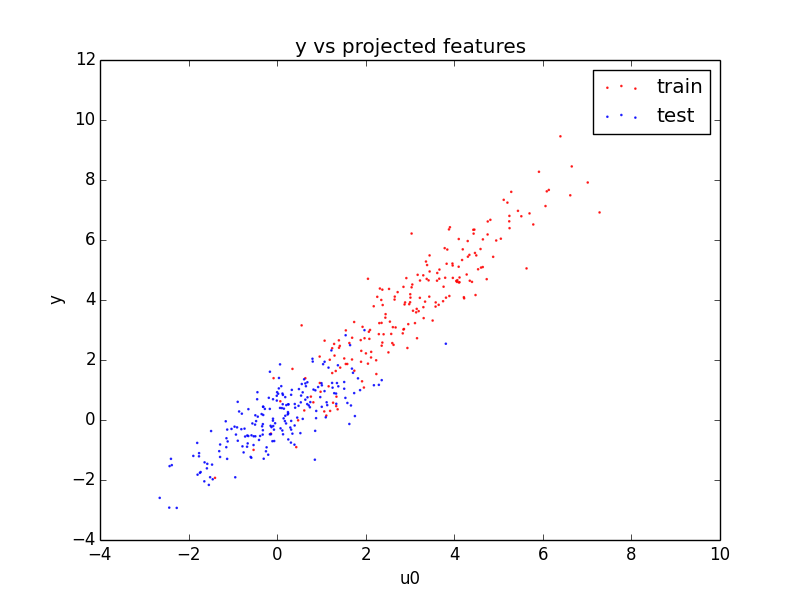

test_P: [[ 0.62469505]
 [ 0.78086881]] obj_val: 0.0465408105255


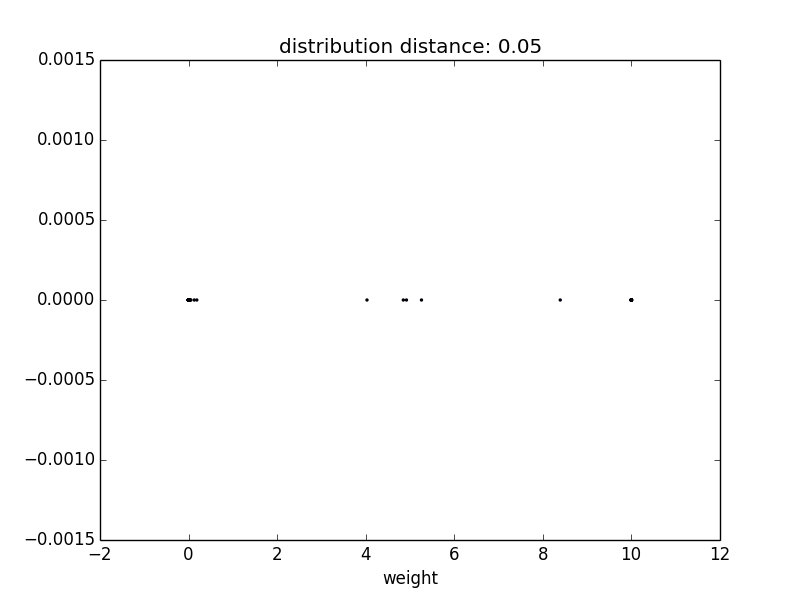

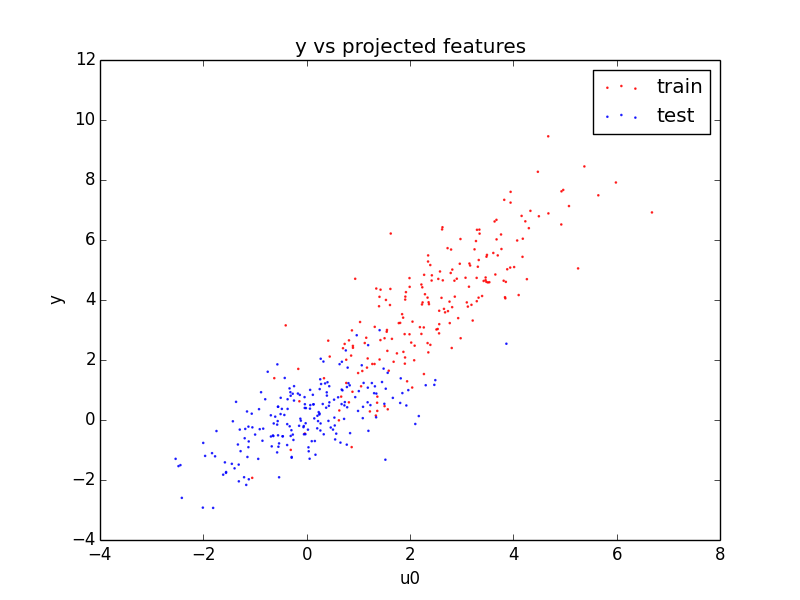

test_P: [[ 0.4472136 ]
 [ 0.89442719]] obj_val: 0.0460017880405


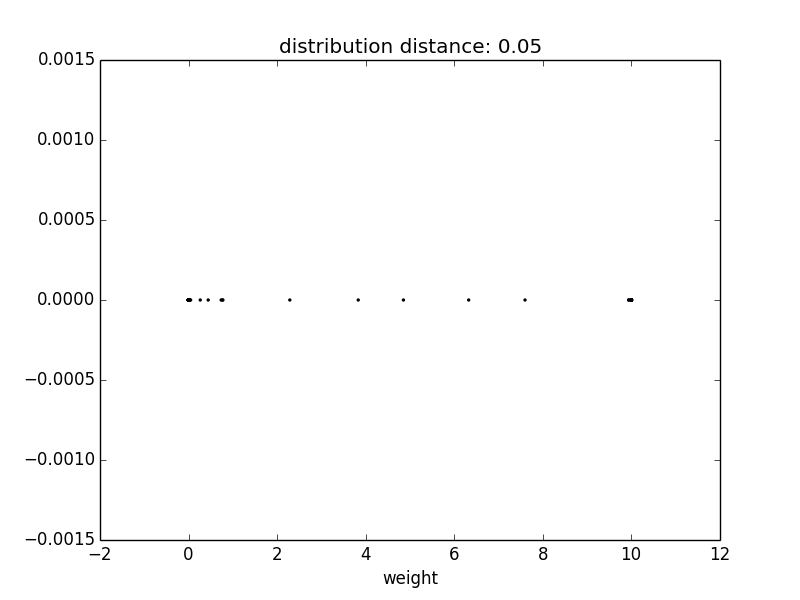

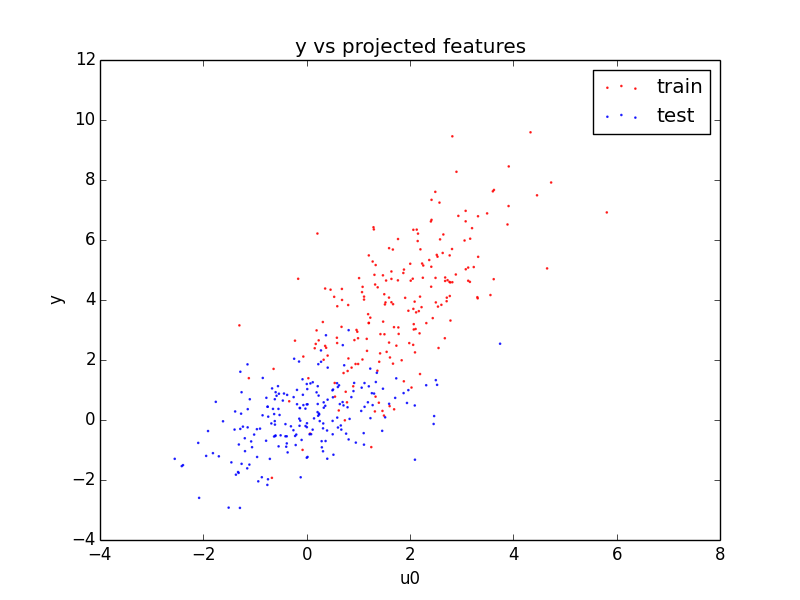

test_P: [[ 0.27472113]
 [ 0.96152395]] obj_val: 0.0240109998033


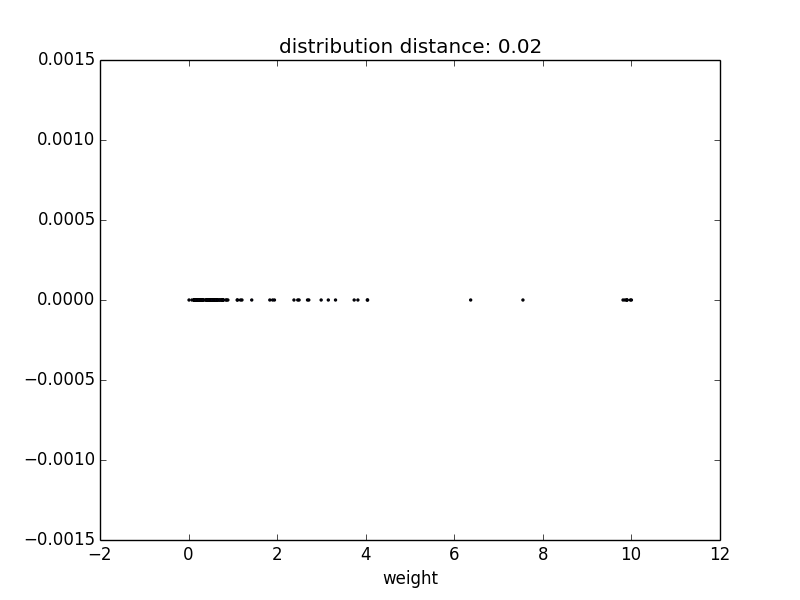

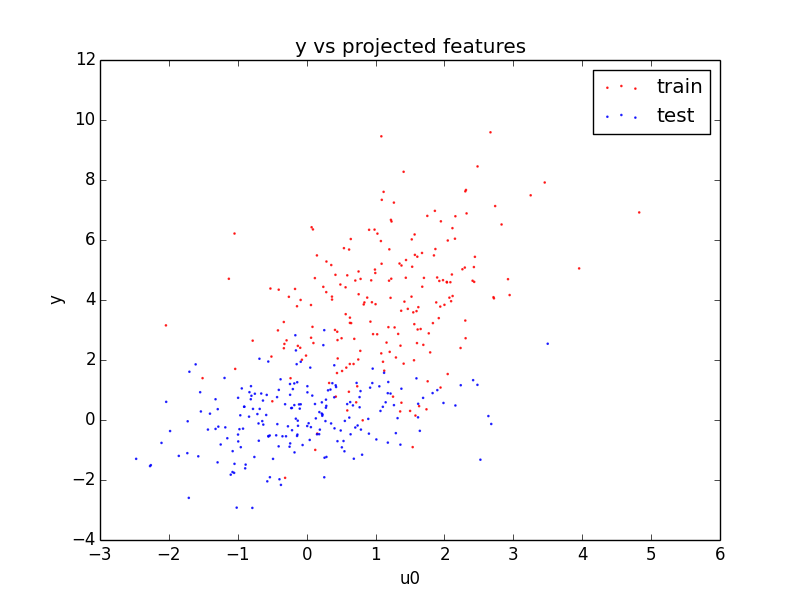

test_P: [[ 0.12403473]
 [ 0.99227788]] obj_val: 0.0101325255914


/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


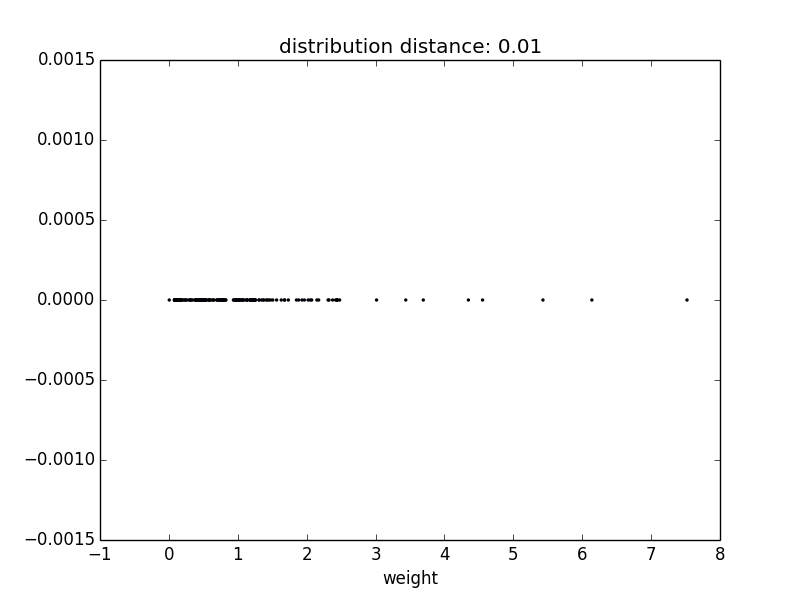

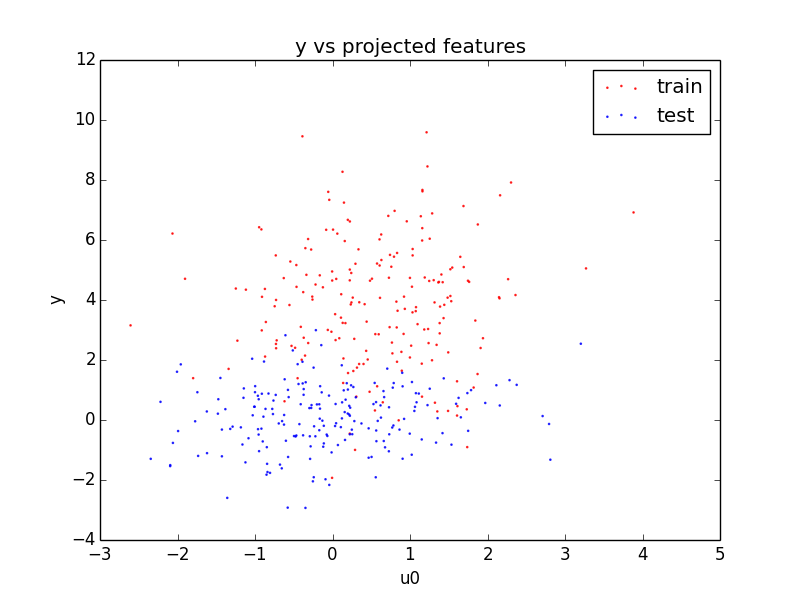

test_P: [[ 0.]
 [ 1.]] obj_val: 0.00696797117183


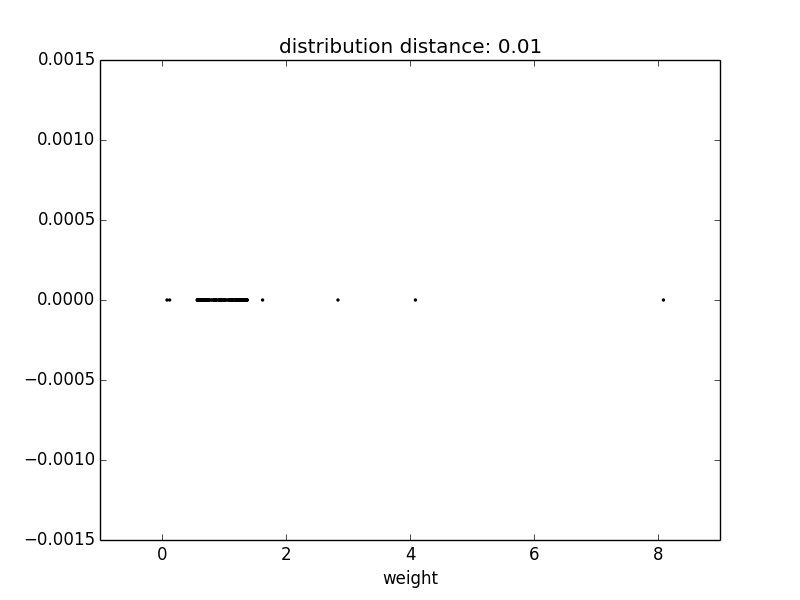

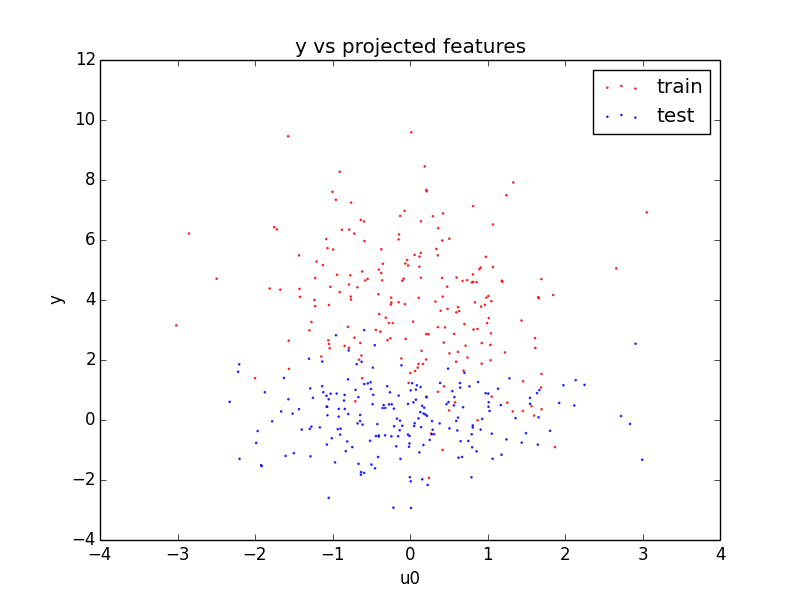

In [26]:
# set the kernels for this testing, based on a fixed P, to get a fixed objective fxn (and gradient)
#for_test_P = kernels.ortho(np.random.normal(size=(x_dim,desired_dim)))
for_test_P = kernels.ortho(np.array([[1,1]]).T)
test_SDR_get_K = get_SDR_get_K(for_test_P, 0)
test_SDR_get_Ky = get_SDR_get_Ky(for_test_P, 0)
test_KMM_get_K = get_KMM_get_K(for_test_P, 0)
print 'test KMM sigma:', test_KMM_get_K.args[0]
test_obj, test_dobj_dP = get_obj_and_dobj_dP(test_KMM_get_K, test_SDR_get_K, test_SDR_get_Ky)
cs = np.linspace(0,1,10)
for c in cs:
    test_P = kernels.ortho(np.array([(1.-c) * u_bases[:,0] + c * u_perp_bases[:,0]]).T)
    print 'test_P:', test_P, 'obj_val:', test_obj(test_P)
    kernels.plot_weights(xs_train, xs_test, test_KMM_get_K, B_max, KMM_eps, test_P)
    kernels.plot_y_vs_u(xs_train, ys_train, test_P, xs_test, ys_test, (x_low,x_high), (y_low,y_high))

In [27]:
#assert False

## optimize

In [28]:
#
def plot_optimize(optimize_info):
    kernels.plot_opt_log(optimize_info)

In [29]:
# define optimizer
def optimize(plot_optimize, manifold, solver, obj, dobj_dP, P_init):
    from pymanopt import Problem
    problem = pymanopt.Problem(manifold=manifold, cost=obj, egrad=dobj_dP, verbosity=0)
    P_fit, optimize_info = solver.solve(problem, x=P_init)
    print 'plot_optimize'
    plot_optimize(optimize_info)
    return P_fit, optimize_info
from pymanopt.solvers import SteepestDescent
from pymanopt.manifolds import Stiefel
solver = pymanopt.solvers.SteepestDescent(logverbosity=2)
manifold = pymanopt.manifolds.Stiefel(x_dim, u_dim)
plot_opt_info = lambda opt_log: None
optimizer = functools.partial(optimize, plot_optimize, manifold, solver)

In [30]:
#
def plot_anneal_step_state(obj, dobj_dP, KMM_get_K, SDR_get_K, SDR_get_Ky, P):
    kernels.plot_weights(xs_train, xs_test, KMM_get_K, B_max, KMM_eps, P)
    kernels.plot_K(xs_train, xs_train, KMM_get_K, P, 'KMM train train')
    kernels.plot_K(xs_train, xs_test, KMM_get_K, P, 'KMM train test')
    kernels.plot_K(xs_train, xs_train, SDR_get_K, P, 'SDR train train')
    kernels.gradient_check(obj, dobj_dP, P)
    kernels.plot_train_vs_test(xs_train, xs_test, P)
    print 'obj_val:', obj(P)
    kernels.plot_y_vs_u(xs_train, ys_train, P, xs_test, ys_test, (x_low,x_high), (y_low,y_high))
    
def plot_anneal_step(obj, dobj_dP, KMM_get_K, SDR_get_K, SDR_get_Ky, P, opt_log):
    plot_anneal_step_state(obj, dobj_dP, KMM_get_K, SDR_get_K, SDR_get_Ky, P)
    print 'annealing step P:', opt_log['final_values']['x']

In [31]:
# 
def plot_anneal(anneal_info):
    obj_val, anneal_step_infos = anneal_info
    fig, ax = plt.subplots()
    ax.scatter(range(len(anneal_step_infos)), [anneal_step_info[2].args[0] for anneal_step_info in anneal_step_infos])
    ax.set_title('KMM sigma')
    ax.set_xlabel('annealing step')
    ax.set_ylabel('sigma')
    basic.display_fig_inline(fig)

In [32]:
# 
def anneal(plot_anneal, plot_anneal_step, num_anneals, optimizer, get_KMM_get_K, get_SDR_get_K, get_SDR_get_Ky, get_obj_and_dobj_dP, P):
    anneal_step_infos = [] # store the things that change
    for step in xrange(num_anneals):
        KMM_get_K = get_KMM_get_K(P,step)
        SDR_get_K = get_SDR_get_K(P,step)
        SDR_get_Ky = get_SDR_get_Ky(P,step)
        obj, dobj_dP = get_obj_and_dobj_dP(KMM_get_K, SDR_get_K, SDR_get_Ky)
        
        print 'plot_anneal_step_state'
        plot_anneal_step_state(obj, dobj_dP, KMM_get_K, SDR_get_K, SDR_get_Ky, P)
        
        P, opt_log = optimizer(obj, dobj_dP, P)
        anneal_step_info = obj, dobj_dP, KMM_get_K, SDR_get_K, SDR_get_Ky, P, opt_log
        plot_anneal_step(*anneal_step_info)
        anneal_step_infos.append(anneal_step_info)
    anneal_info = (obj(P), anneal_step_infos)
    print 'plot_anneal'
    plot_anneal(anneal_info)
    return P, anneal_info
num_anneals = 1
annealer = functools.partial(anneal, plot_anneal, plot_anneal_step, num_anneals, optimizer, get_KMM_get_K, get_SDR_get_K, get_SDR_get_Ky, get_obj_and_dobj_dP)

In [33]:
#
def plot_multiples(multiples_info):
    obj_vals = []
    best_obj_val = None
    best_anneal_step_info = None
    for anneal_info in multiples_info:
        obj_val, anneal_step_infos = anneal_info
        obj, dobj_dP, KMM_get_K, SDR_get_K, SDR_get_Ky, P, opt_log = anneal_step_infos[-1]
        print 'this anneal obj_val:', obj_val
        kernels.plot_y_vs_u(xs_train, ys_train, P, xs_test, ys_test, (x_low,x_high), (y_low,y_high))
        obj_vals.append(obj_val)
        if obj_val > best_obj_val:
            best_obj_val = obj_val
            best_anneal_step_info = anneal_step_infos[-1]
    #plot_anneal_step(*best_anneal_step_info)
    print 'obj_vals', obj_vals

In [34]:
#
def multiples(plot_multiples, num_trials, annealer, P_shape):
    trial_infos = []
    best_P = None
    best_obj_val = None
    for i in xrange(num_trials):
        P_init = kernels.ortho(np.random.normal(size=P_shape))
        P, anneal_info = annealer(P_init)
        trial_infos.append(anneal_info)
        (obj_val, anneal_step_infos) = anneal_info
        if best_P is None or obj_val < best_obj_val:
            best_P = P
            best_obj_val = obj_val
    multiples_info = trial_infos
    plot_multiples(multiples_info)

plot_anneal_step_state


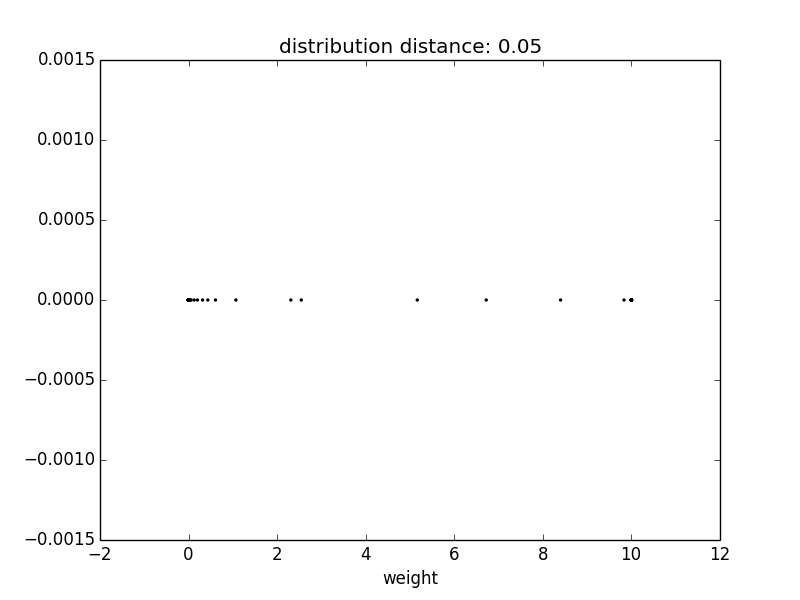

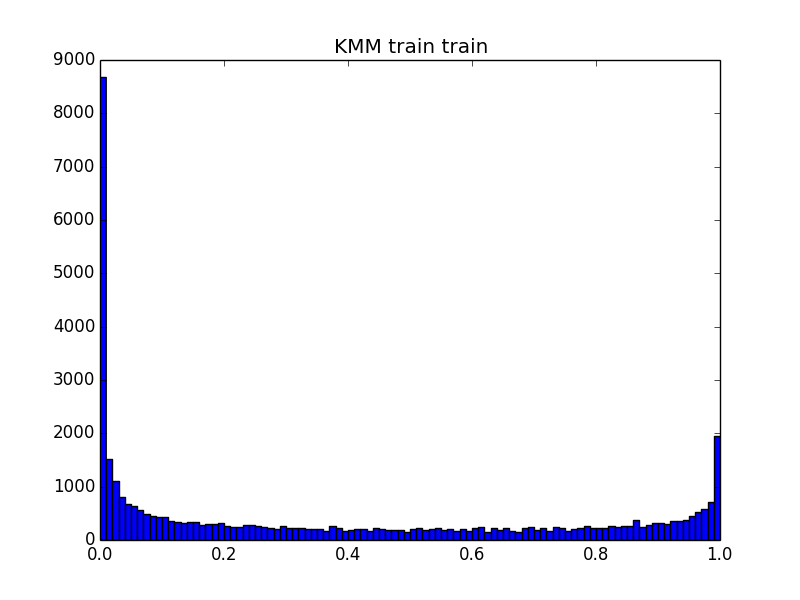

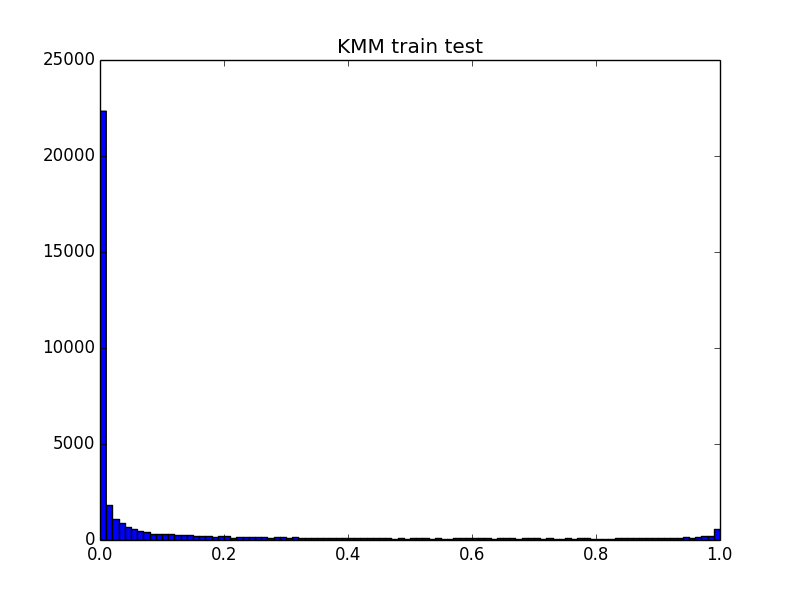

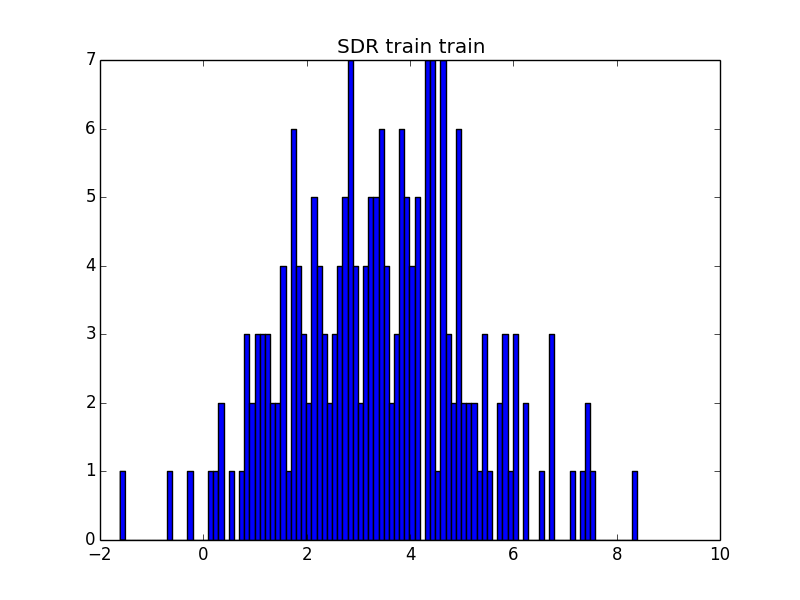

numerical gradient:
[[-0.08928143]
 [ 0.08590072]]
analytical gradient:
num_tight: 109
solver error: 0.000736910594657
[[-0.01072295]
 [ 0.00332545]]


/Users/fultonw/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/autograd/core.py:37: UserWarning: Output seems independent of input. Returning zero gradient.
  warnings.warn("Output seems independent of input. Returning zero gradient.")


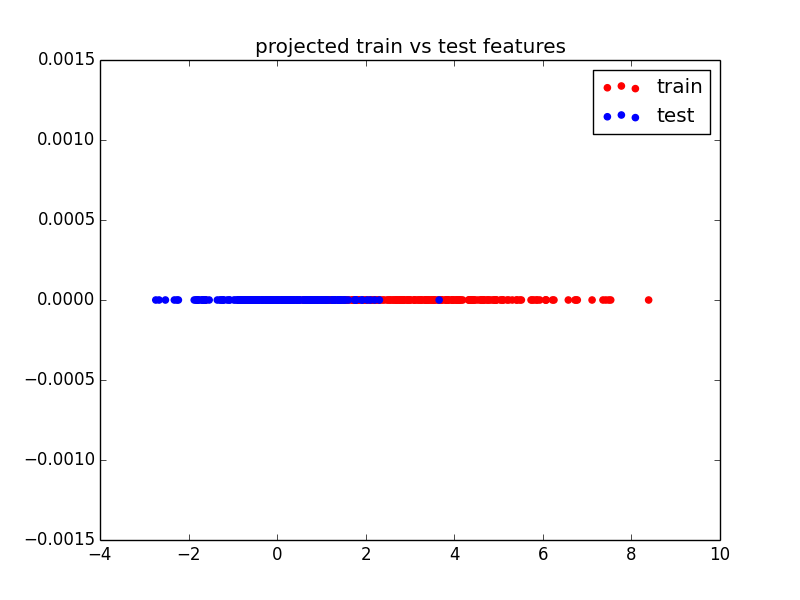

obj_val: 0.046316665158


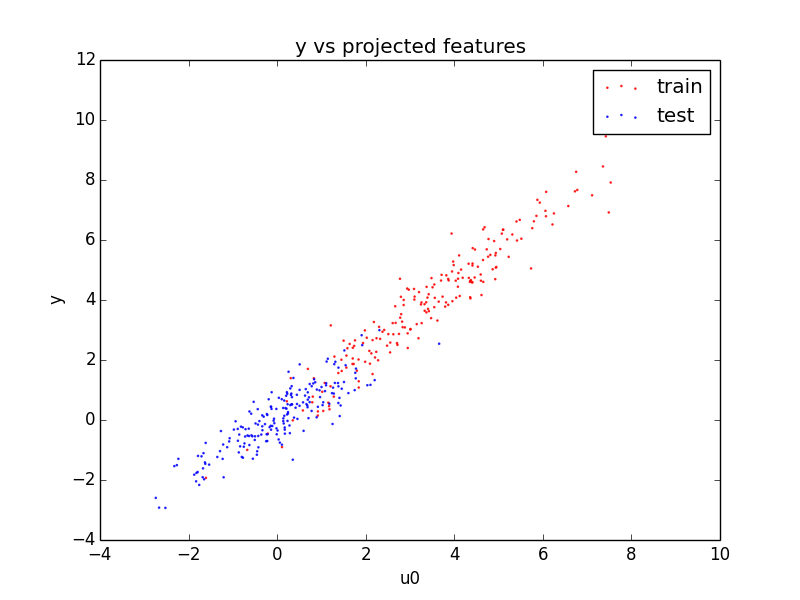

num_tight: 109
solver error: 0.000736910594657
num_tight: 70
solver error: 0.000682861446714
num_tight: 0
solver error: 0.000950238377824
num_tight: 0
solver error: 0.00160776127975
num_tight: 0
solver error: 0.000420858511483
num_tight: 0
solver error: 0.000434964564568
num_tight: 0
solver error: 0.000427547669142
num_tight: 0
solver error: 0.00039548783362
num_tight: 0
solver error: 0.000321384114254
plot_optimize


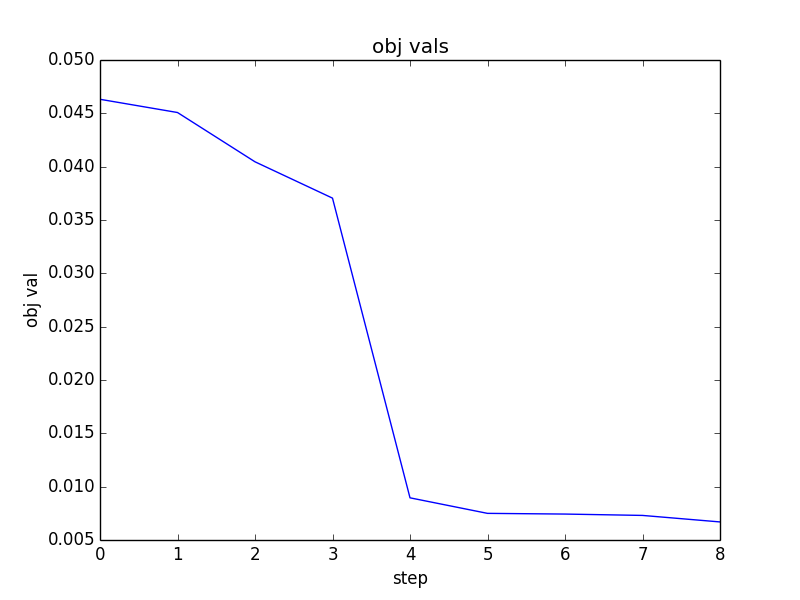

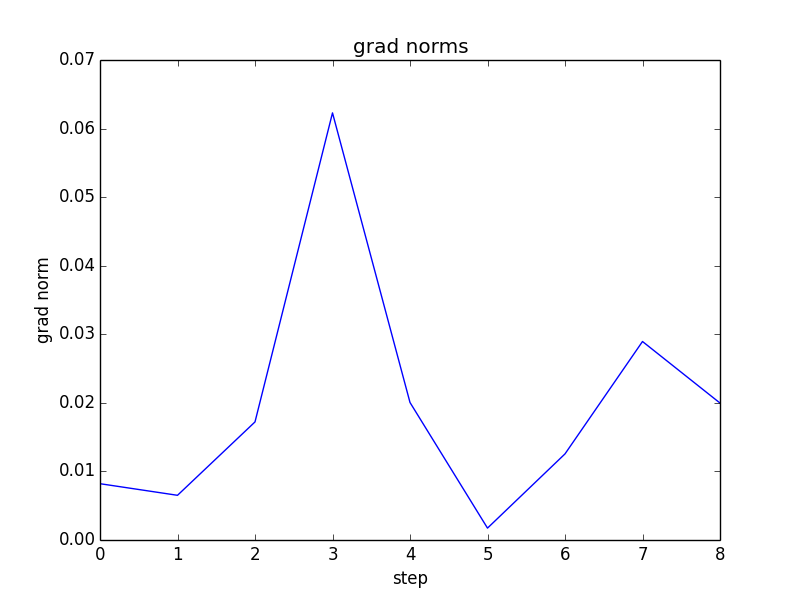

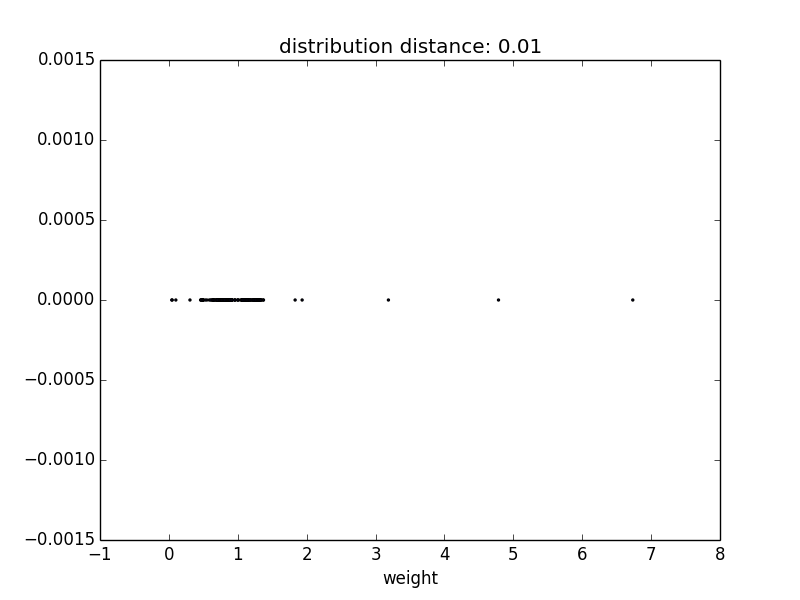

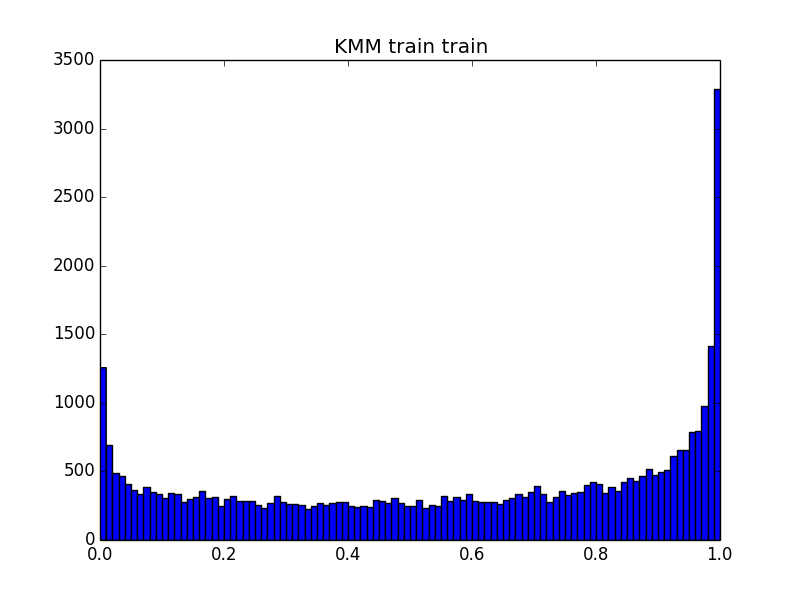

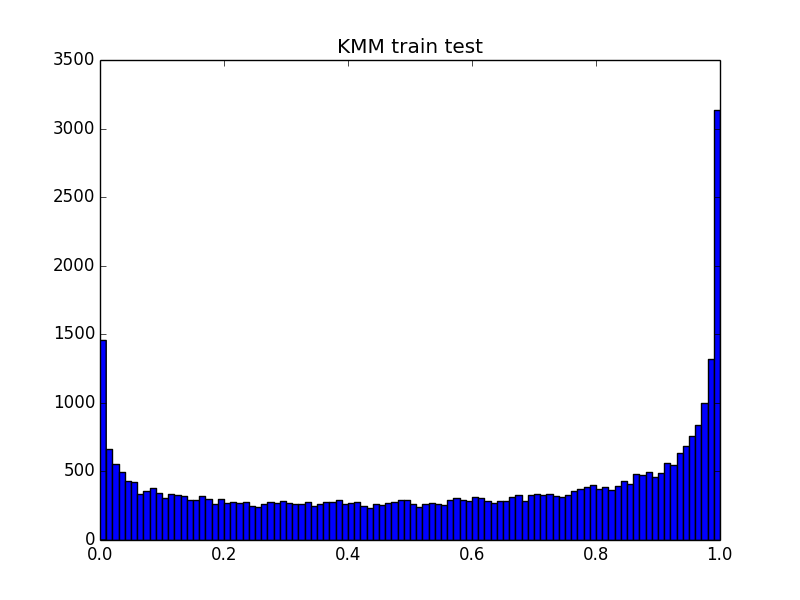

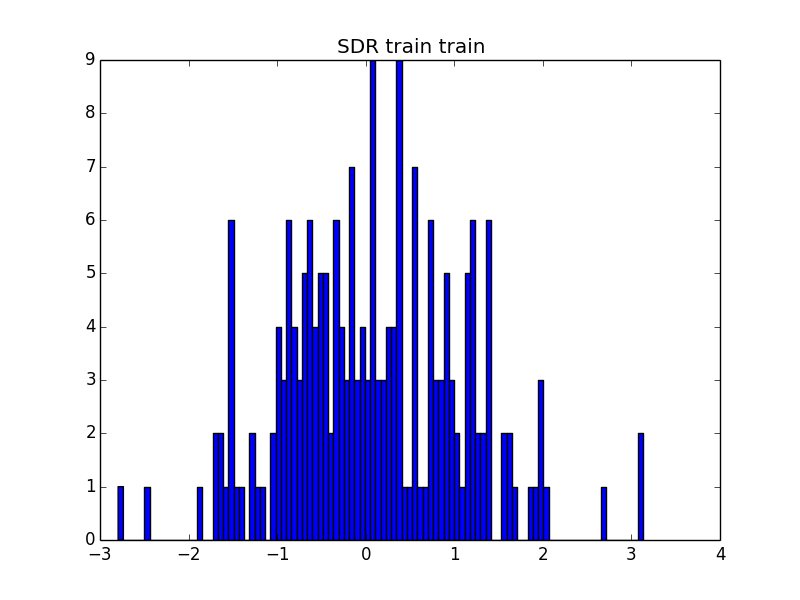

numerical gradient:
[[-0.06904926]
 [-0.00464821]]
analytical gradient:
num_tight: 0
solver error: 0.000321384114254
[[ 0.01993282]
 [ 0.00145161]]


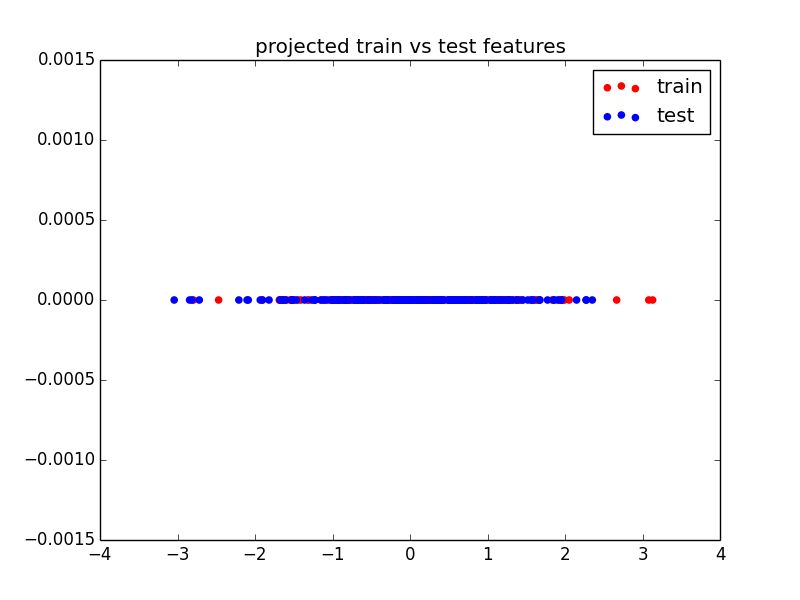

obj_val: 0.00669393863128


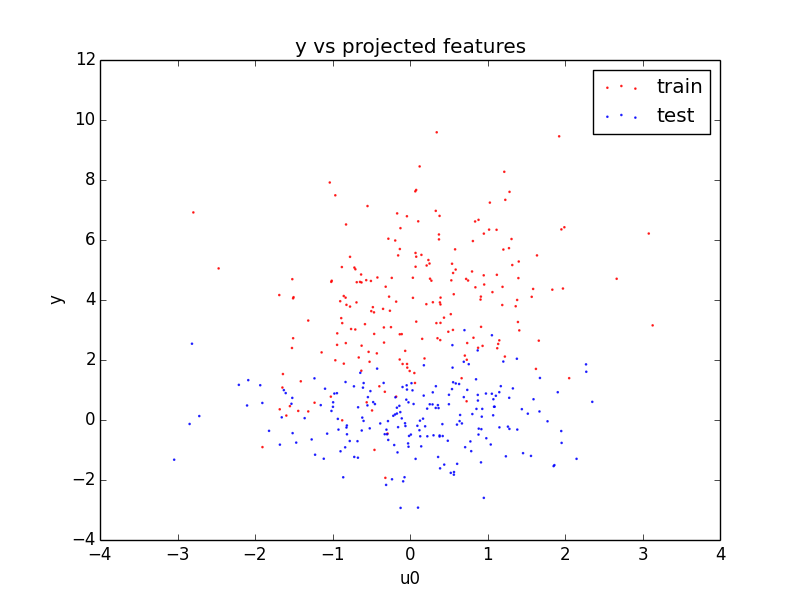

annealing step P: [[ 0.03739846]
 [-0.99930043]]
plot_anneal


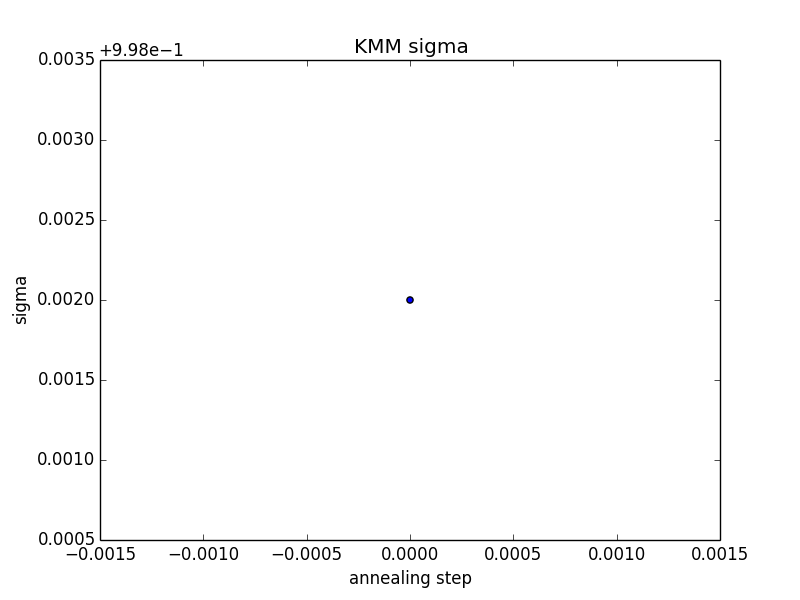

plot_anneal_step_state


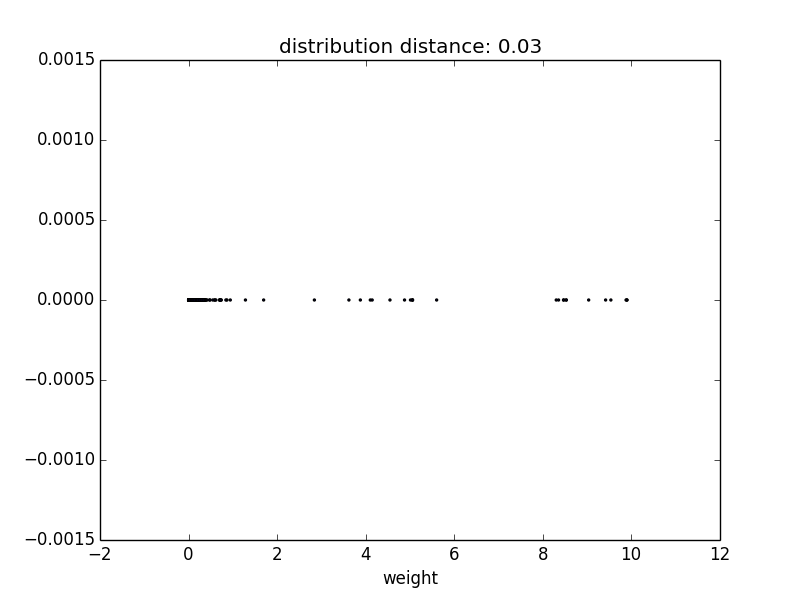

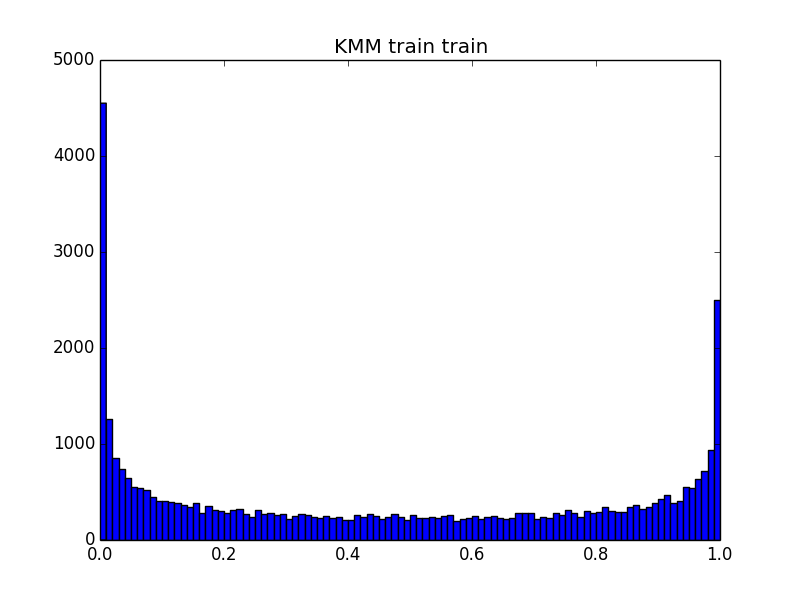

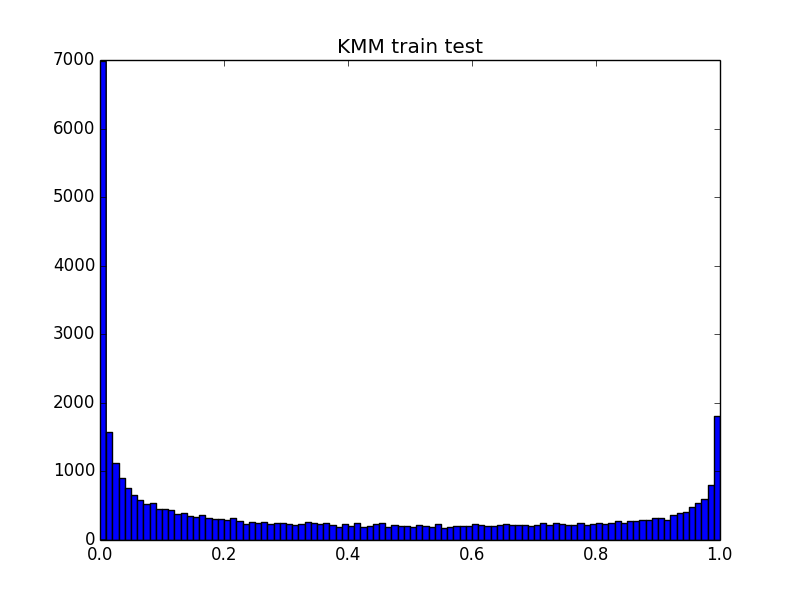

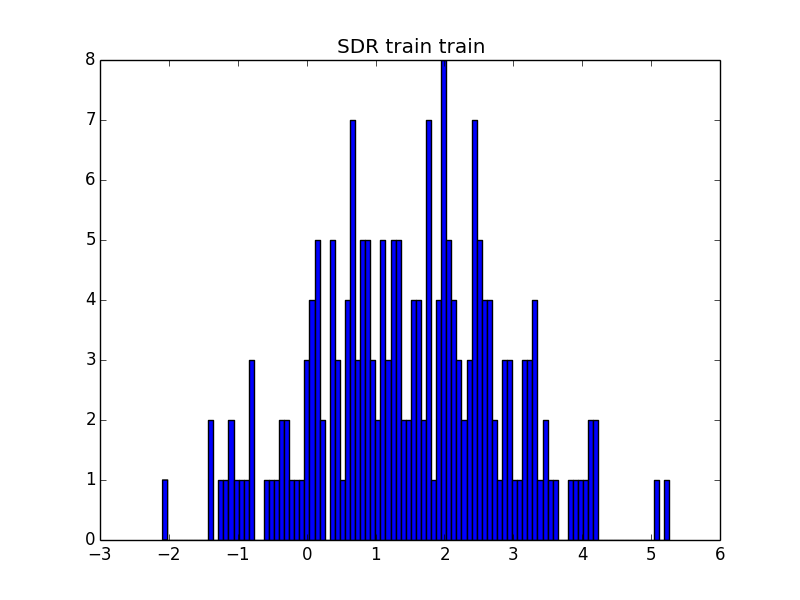

numerical gradient:
[[ 0.14958352]
 [-0.00391894]]
analytical gradient:
num_tight: 0
solver error: 0.00137385408794
[[ 0.023129  ]
 [ 0.01502344]]


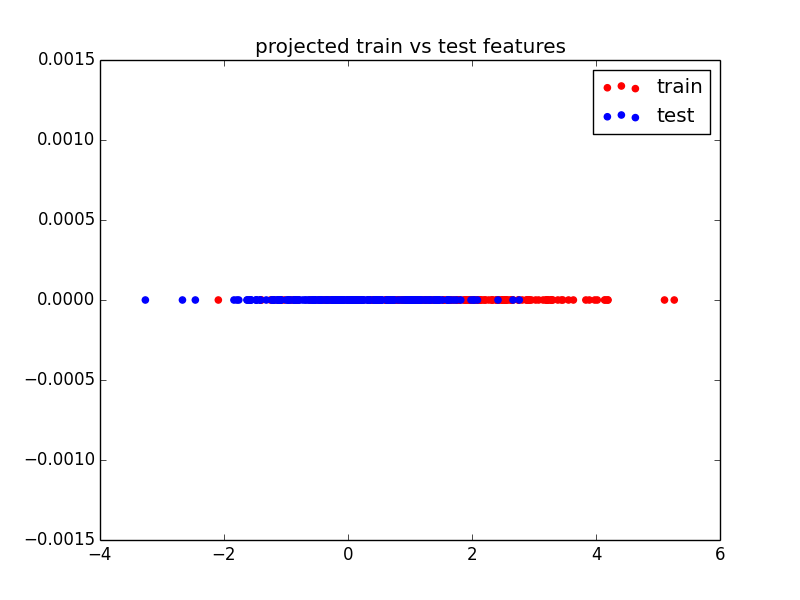

obj_val: 0.0311994676978


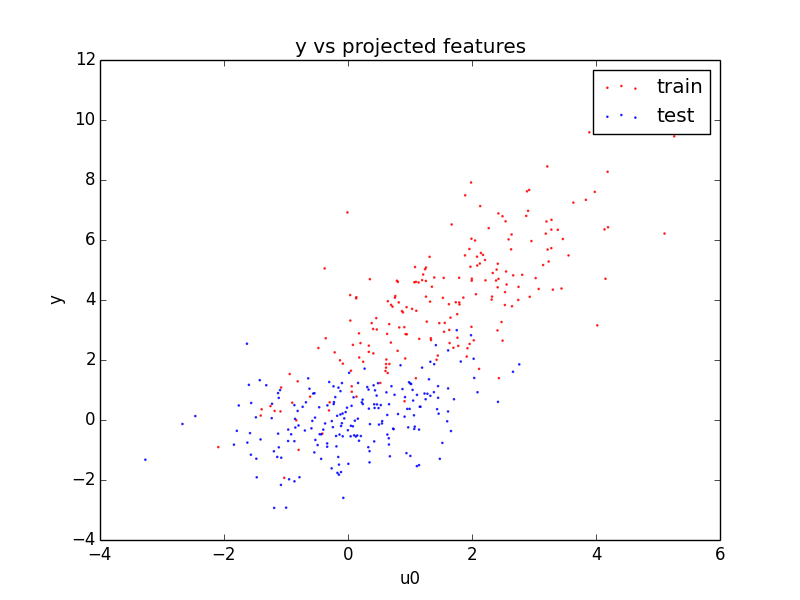

num_tight: 0
solver error: 0.00137385408794
num_tight: 0
solver error: 0.0004024961352
num_tight: 0
solver error: 0.000436050211385
num_tight: 0
solver error: 0.00032800917695
num_tight: 0
solver error: 0.000353501963886
num_tight: 0
solver error: 0.000319749782003
num_tight: 0
solver error: 0.000317202672229
plot_optimize


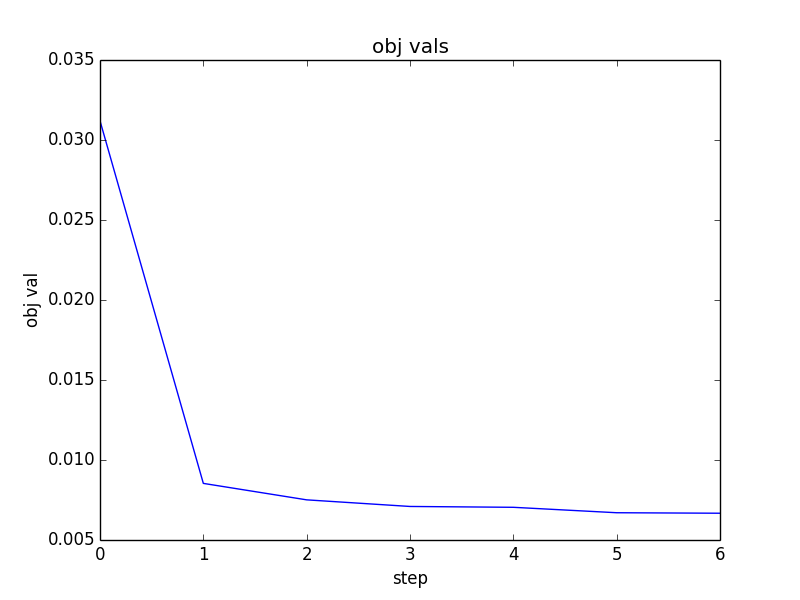

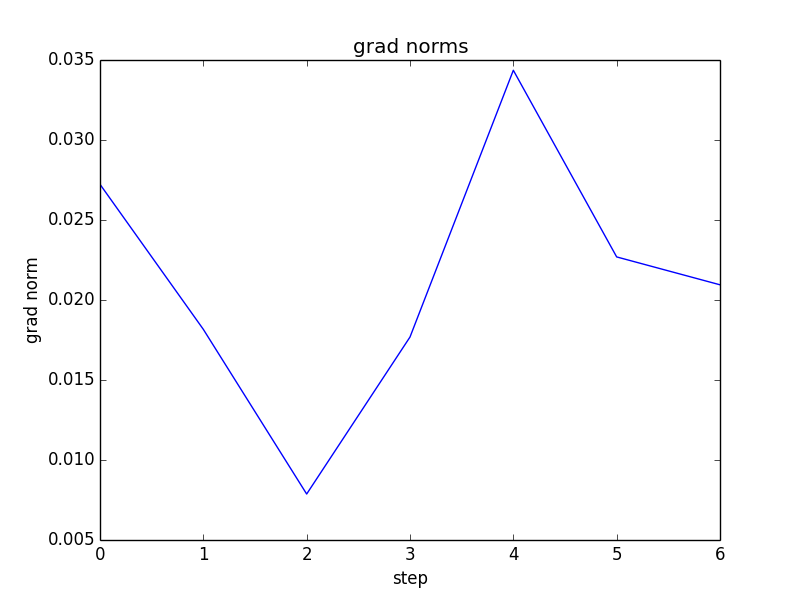

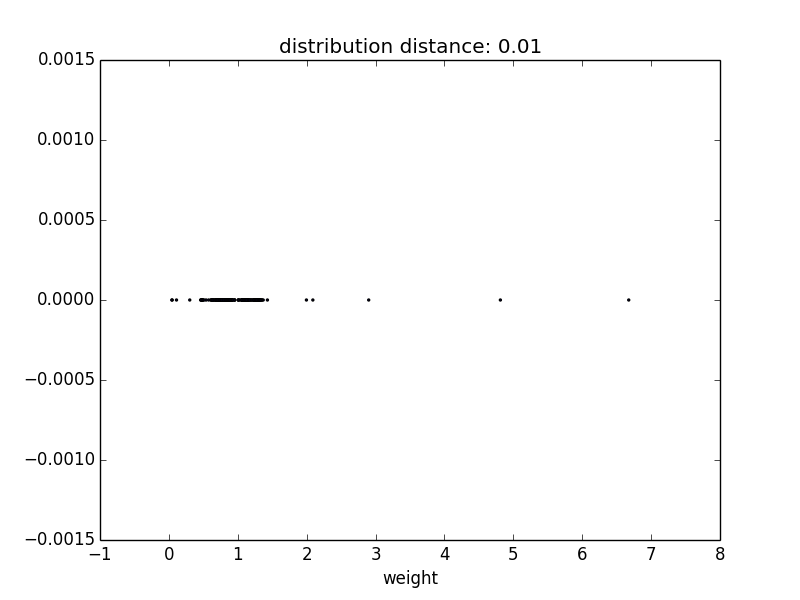

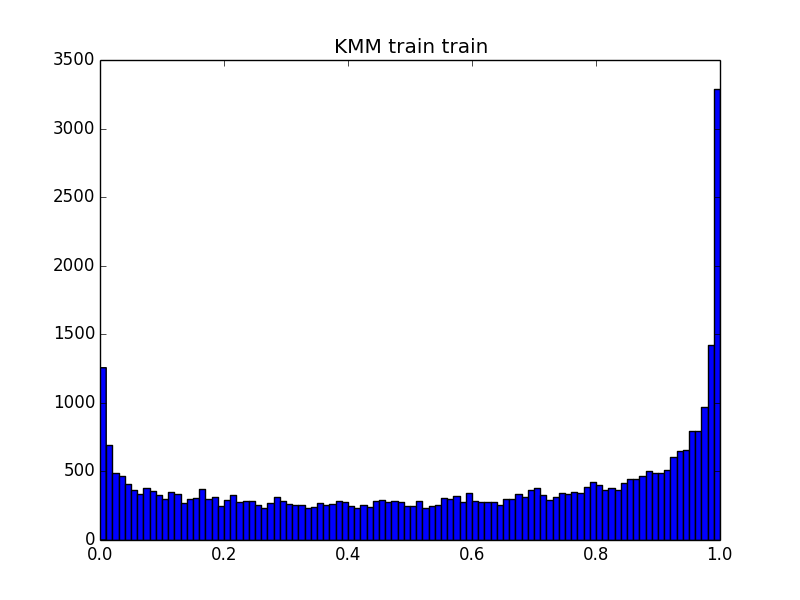

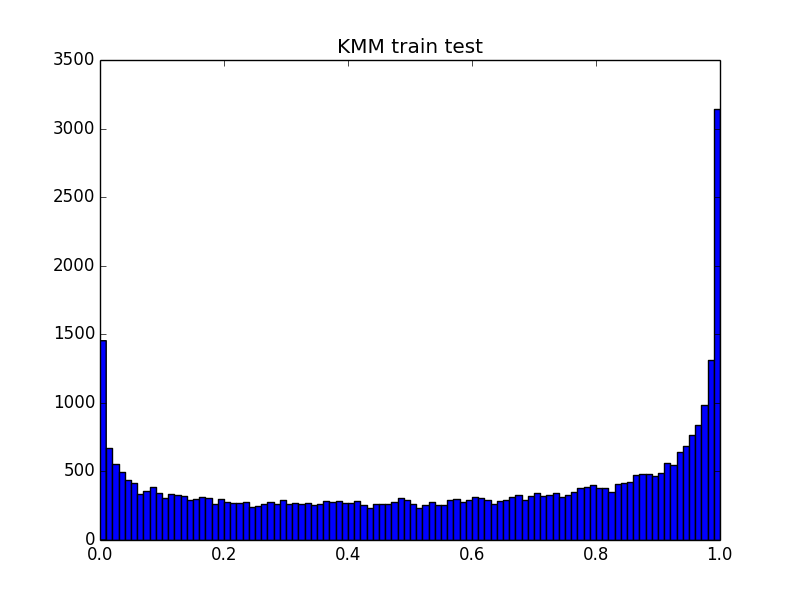

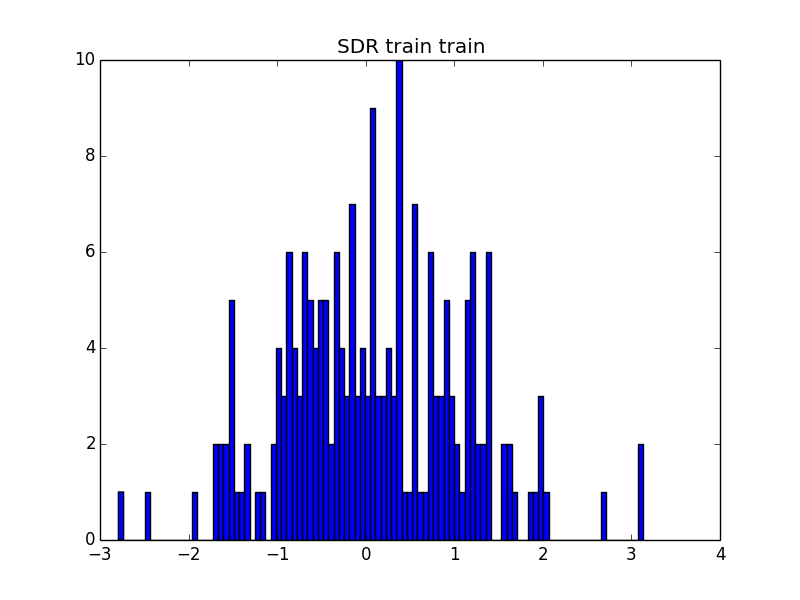

numerical gradient:
[[-0.03422818]
 [-0.0035958 ]]
analytical gradient:
num_tight: 0
solver error: 0.000317202672229
[[ 0.02090698]
 [ 0.00153975]]


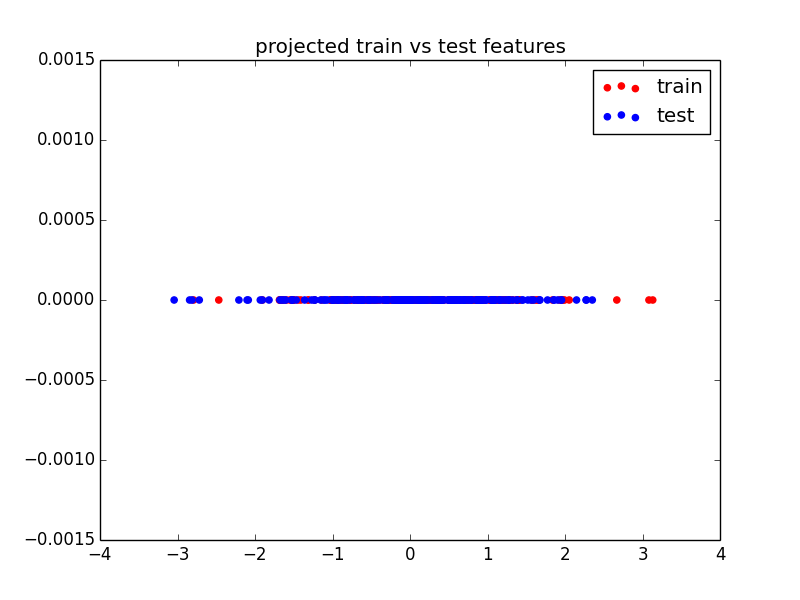

obj_val: 0.00667317831328


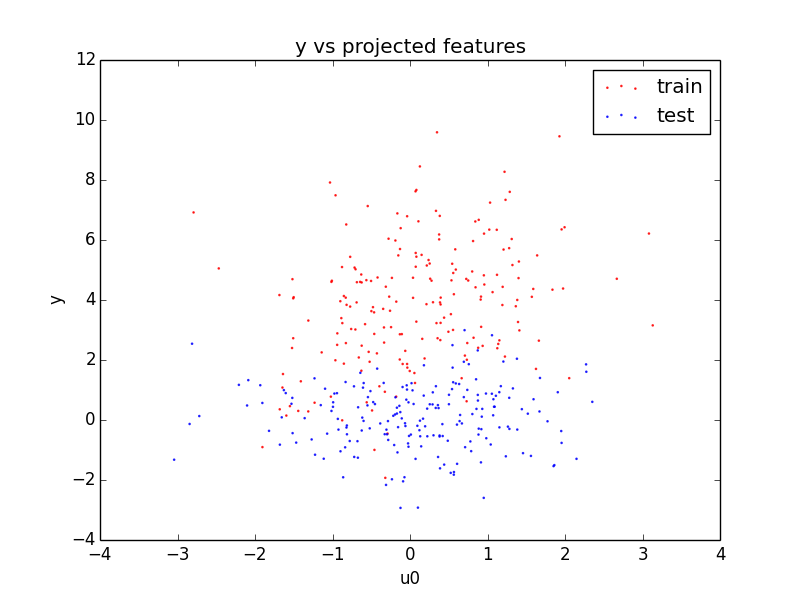

annealing step P: [[ 0.03779397]
 [-0.99928555]]
plot_anneal


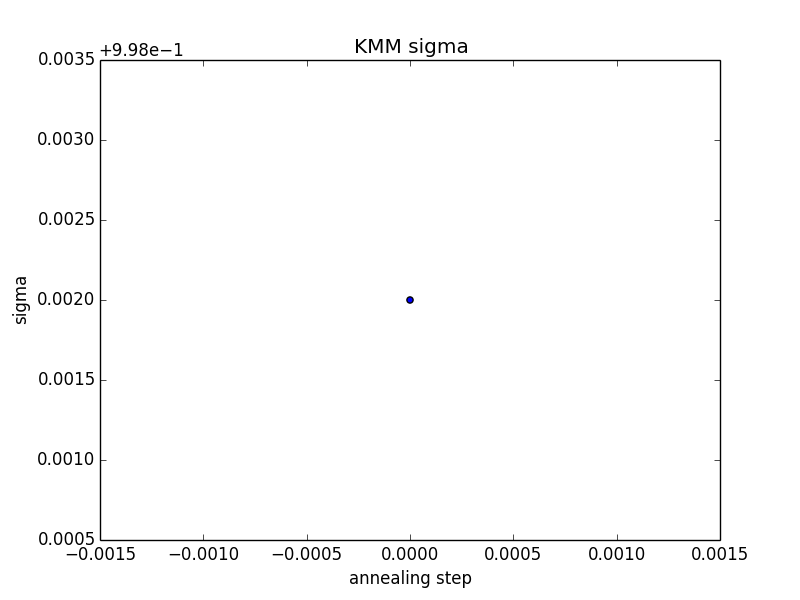

this anneal obj_val: 0.00669393863128


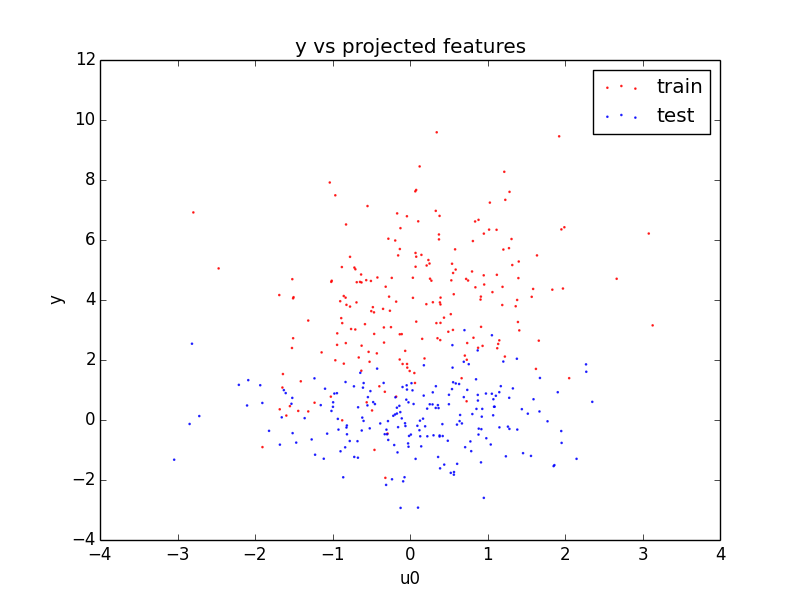

this anneal obj_val: 0.00667317831328


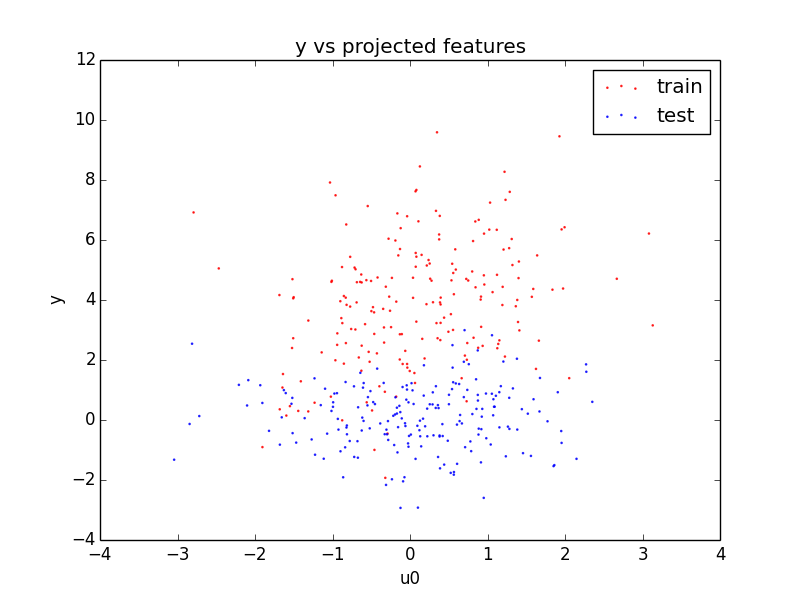

obj_vals [0.0066939386312824456, 0.006673178313275626]


In [35]:
#
multiples(plot_multiples, 2, annealer, (x_dim,desired_dim))

In [36]:
assert False

AssertionError: 

In [ ]:
# define P_init
#P_init = kernels.ortho(np.random.normal(size=(x_dim,v_dim)))
#P_init = kernels.ortho(np.array([[1.,0.]]).T)
#P_init = kernels.ortho(np.array([[1,-2.3]]).T)
#P_init = kernels.ortho(np.array([[0.,1.]]).T)
P_init = kernels.ortho(np.array([[0.19839015,0.98012313]]).T)

In [ ]:
# run
annealer(P_init)

In [ ]:
assert False